In [1]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model

import tarfile
from urllib.request import urlretrieve
import os
import nltk
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
%matplotlib inline

## Reading in the data

In [2]:
url = 'http://www.cs.cmu.edu/~ark/personas/data/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists("datasets"):
    os.mkdir("datasets")
  if not os.path.exists(os.path.join("datasets", filename)):
    print('Downloading file...')
    filename, _ = urlretrieve(url + filename, os.path.join("datasets",filename))
  else:
    print('File exists ...')

  print("Extracting the file")
  tar = tarfile.open(os.path.join("datasets",filename), "r:gz")
  tar.extractall("datasets")
  tar.close()
    
  statinfo = os.stat(os.path.join("datasets",filename))
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % os.path.join("datasets",filename))
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + os.path.join("datasets",filename) + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('MovieSummaries.tar.gz', 48002242)

File exists ...
Extracting the file
Found and verified datasets\MovieSummaries.tar.gz


In [3]:
def read_data(filename, n_lines):
    """ Reading the zip file to extract text """
    docs = []
    i = 0
    with open(filename, 'r', encoding='utf-8') as f:
        for row in f:
            file_string = nltk.word_tokenize(row)
            # First token is the movie ID
            docs.append(' '.join(file_string[1:]))
            i += 1
            if n_lines and i == n_lines:
                break
    return docs

docs = read_data(os.path.join("datasets", "MovieSummaries", 'plot_summaries.txt'), 10000)
print("Read in {} documents".format(len(docs)))

Read in 10000 documents


## Defining the tokenizer

In [4]:
v_size = 3000
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)

## Computing the co-occurence matrix

Computes the co-occurence matrix and save it to the disk can either load the existing matrix or compute a new one by changing `generate_cooc` variable.

In [6]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            context_window = sequence[i-window_size: i+window_size+1]
            distances = np.abs(np.arange(-window_size, window_size+1))
            distances[window_size] = 1.0
            nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            nom[window_size] = 0.0

            if use_weighting:
                cooc_mat[wi, context_window] += nom/distances    # Update element
            else:
                cooc_mat[wi, context_window] += nom
    
    return cooc_mat    

if generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, True)
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))

Cooc matrix of type lil_matrix was loaded from disk


## Validating the co-occurrence matrix
Taking a specific word and plotting the frequencies of the most common 25 co-occurinng words. Making sure that the word distribution makes sense (Zif's law) and the co-occuring words are valid (visually)

([<matplotlib.axis.XTick at 0x180d56e77b8>,
 <a list of 25 Text xticklabel objects>)

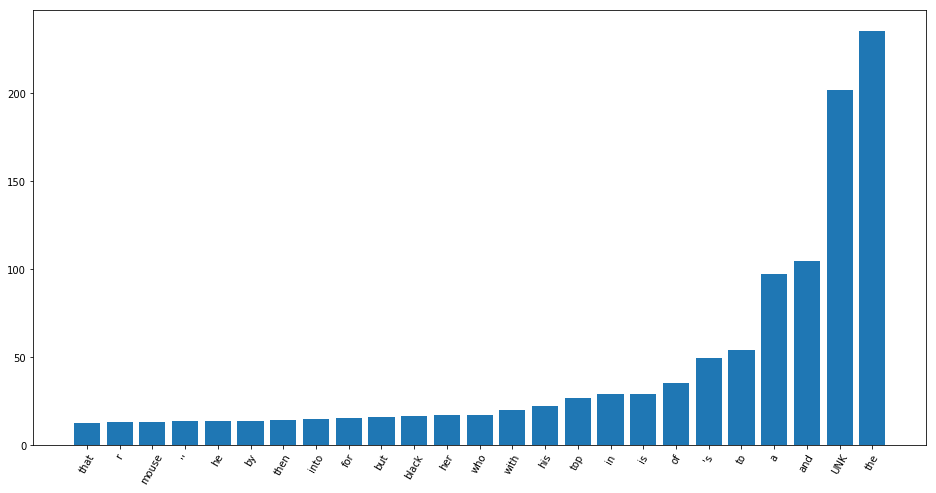

In [31]:
word = 'cat'
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
max_ind = np.argsort(cooc_vec)[-25:]
#print(max_ind)
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

## Defining GloVe model with Keras

In order to define the GloVe model, a custom loss function is required. However, GloVe loss essentially boils down to a mean square error, which makes it easier to define as a custom loss function. Let's have a quick look. GloVe loss is defined as,

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_i^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

where $X_{ij}$ is the $i,j$ cell of the co-occurence matrix and $w,\tilde{w},b,\tilde{b}$ are weights and biases. For a full explanation refer the [original paper](https://nlp.stanford.edu/pubs/glove.pdf). When you play around with parenthesis you will start seeing the squared loss.

$J = \sum_{i,j=1}^{V} f(X_{ij})\{(w_i^T\tilde{w}_j + b_i + \tilde{b}_j) - log(X_{ij})\}^2$, 

which is like,

$J = \sum A ( B - C)^2$


In [32]:
def create_glove_model(v_size):
    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 96, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 96, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model


## Clearning session and analysing the model

In [33]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 96)        288000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 96)        288000      input_2[0][0]                    
__________________________________________________________________________________________________
flatten (F

## Run and eval Glove¶

In [34]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
batch_size =128
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))


c:\anaconda3\envs\tekbac.deeplearning\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loss in epoch 0: 3080.0761646789542
Loss in epoch 1: 0.7902729443804617
Loss in epoch 2: 0.3762087574241899
Loss in epoch 3: 0.26511143066882104
Loss in epoch 4: 0.2176792402315259
Loss in epoch 5: 0.192896554466248
Loss in epoch 6: 0.17878403617505492
Loss in epoch 7: 0.1682449689781125
Loss in epoch 8: 0.1619124566234104
Loss in epoch 9: 0.1563303735583753


## Saving the model and the embeddings to the disk

In [38]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model.h5')

## Printing out some similar words of a set of valid words

In [ ]:
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(100)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        

valid_words = get_valid_words(docs, 100, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w.csv'))
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))